In [1]:
# data manipulation
import pandas as pd
import numpy as np

# pre processing
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

# model
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

# metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

# plotting
import matplotlib.pyplot as plt

# saving
import joblib

In [2]:
X_train = joblib.load('data/X_train_preprocessed.pkl')
X_test = joblib.load('data/X_test_preprocessed.pkl')
y_train = joblib.load('data/y_train_preprocessed.pkl')
y_test = joblib.load('data/y_test_preprocessed.pkl')

In [3]:
scoring = {
    'accuracy': 'accuracy',
    'precision_macro': make_scorer(precision_score, average='macro'),
    'recall_macro': make_scorer(recall_score, average='macro'),
    'f1_macro': make_scorer(f1_score, average='macro')
}

In [4]:
rf = RandomForestClassifier()
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [10]:
param_grid = {
    'n_estimators': [100, 200, 300, 500],          
    'max_depth': [None, 10, 20, 30, 50],             
    'min_samples_split': [2, 5, 10],                 
    'min_samples_leaf': [1, 2, 4],                   
    'max_features': [None, 'sqrt', 'log2'],        
    'bootstrap': [True, False],                      
    'criterion': ['gini', 'entropy']                 
}

In [12]:
def train_grid_search(X, y, estimator, grid):
    grid_search = GridSearchCV(
        estimator=estimator,
        param_grid=grid,
        cv=skf,
        scoring=scoring,
        refit='f1_macro',
        n_jobs=-1,
        return_train_score=True,
        verbose=1
    )

    grid_search.fit(X, y)

    return grid_search

In [ ]:
def get_results(g_search):
    results = pd.DataFrame(g_search.cv_results_)
    
    results = results[
        [
            'mean_fit_time', 'mean_score_time', 'param_n_estimators', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf',
            'param_max_features', 'param_bootstrap', 'param_criterion', 'mean_train_accuracy', 'mean_test_accuracy', 'rank_test_accuracy', 
            'mean_train_precision_macro', 'mean_test_precision_macro', 'rank_test_precision_macro', 'mean_train_recall_macro', 
            'mean_test_recall_macro', 'rank_test_recall_macro', 'mean_train_f1_macro', 'mean_test_f1_macro', 'rank_test_f1_macro'
        ]
    ]

    results = results.sort_values(by='mean_test_f1_macro', ascending=False)
    return results

In [8]:
pd.set_option('display.max_columns', None)

In [ ]:
grid_search = train_grid_search(X_train, y_train, rf, param_grid)

Fitting 10 folds for each of 2160 candidates, totalling 21600 fits


KeyError: "['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features', 'bootstrap', 'criterion'] not in index"

In [16]:
results = get_results(grid_search)

In [17]:
results.head(10)

,mean_fit_time,mean_score_time,param_n_estimators,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_max_features,param_bootstrap,param_criterion,mean_train_accuracy,mean_test_accuracy,rank_test_accuracy,mean_train_precision_macro,mean_test_precision_macro,rank_test_precision_macro,mean_train_recall_macro,mean_test_recall_macro,rank_test_recall_macro,mean_train_f1_macro,mean_test_f1_macro,rank_test_f1_macro
0,1.585084,0.021176,100,None,2,1,None,True,gini,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1
1086,7.849628,0.036084,300,None,5,1,None,False,gini,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1
1000,1.658830,0.016453,100,50,5,4,None,True,entropy,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1
1001,3.153960,0.023078,200,50,5,4,None,True,entropy,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1
1002,5.009163,0.029107,300,50,5,4,None,True,entropy,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1
1003,8.122469,0.043330,500,50,5,4,None,True,entropy,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1
1004,1.629187,0.016600,100,50,10,4,None,True,entropy,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1
1005,3.184203,0.023430,200,50,10,4,None,True,entropy,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1
1006,4.766666,0.031101,300,50,10,4,None,True,entropy,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1
1007,7.985741,0.045419,500,50,10,4,None,True,entropy,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1


In [60]:
def view_test_metrics(train_metrics: bool, filter_top_n: int, results_df: pd.DataFrame):
    if train_metrics:
        metrics = [
            "mean_train_accuracy", "mean_test_accuracy",
            "mean_train_precision_macro", "mean_test_precision_macro",
            "mean_train_recall_macro", "mean_test_recall_macro",
            "mean_train_f1_macro", "mean_test_f1_macro"
        ]
    else:
        metrics = [
            "mean_test_accuracy",
            "mean_test_precision_macro",
            "mean_test_recall_macro",
            "mean_test_f1_macro"
        ]

    if filter_top_n:
        results_df = results_df.nsmallest(filter_top_n, "rank_test_f1_macro")

    param_cols = [
        'param_n_estimators', 'param_max_depth', 'param_min_samples_split', 
        'param_min_samples_leaf', 'param_bootstrap', 'param_criterion'
    ]
    plot_df = results_df.melt(
        id_vars=param_cols,      # keep these columns "as is"
        value_vars=metrics,      # the columns we want to "unpivot"
        var_name="metric",       # new column with the metric name
        value_name="score"       # new column with the metric value
    )

    plt.figure(figsize=(12, 8))


    for combo, group in plot_df.groupby(param_cols):
        # Sort the group by metric name (if desired)
        group = group.sort_values("metric")
        # Create a label for this parameter combination
        label_str = ", ".join(f"{col}={val}" for col, val in zip(param_cols, combo))
        
        # Separate train and test metrics using .str.startswith on the 'metric' column
        train_group = group[group["metric"].str.startswith("mean_train")]
        test_group = group[~group["metric"].str.startswith("mean_train")]

        # Plot training metrics with a dashed line and an 'x' marker (with transparency)
        if not train_group.empty:
            plt.plot(train_group["metric"], train_group["score"], 
                     marker='x', linestyle='dashed', alpha=0.7,
                     label=label_str + " (train)")
        # Plot test metrics with a solid line and an 'o' marker (with transparency)
        if not test_group.empty:
            plt.plot(test_group["metric"], test_group["score"], 
                     marker='o', linestyle='solid', alpha=0.7,
                     label=label_str + " (test)")

    plt.xlabel("Metric")
    plt.ylabel("Score")
    plt.title("Comparison of Mean Test Metrics")
    plt.xticks(rotation=45)
    # Adjust the legend to avoid cluttering the plot
    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()  

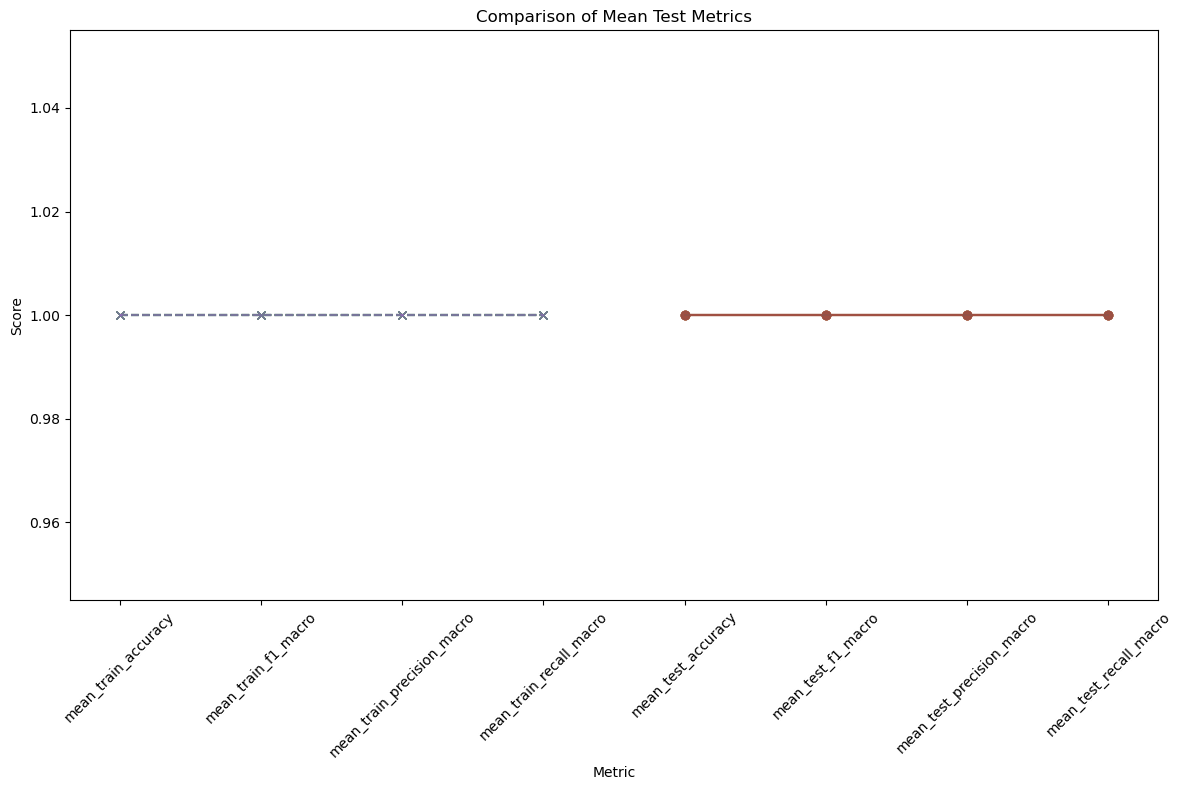

In [61]:
view_test_metrics(True, 10, results)

Como vários modelos alcalçaram as métricas máximas, podemos pegar o modelo dentre esses que é o mais leve:

In [ ]:
    results = results[
        [
            'mean_fit_time', 'mean_score_time', 'param_n_estimators', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf',
            'param_max_features', 'param_bootstrap', 'param_criterion', 'mean_train_accuracy', 'mean_test_accuracy', 'rank_test_accuracy', 
            'mean_train_precision_macro', 'mean_test_precision_macro', 'rank_test_precision_macro', 'mean_train_recall_macro', 
            'mean_test_recall_macro', 'rank_test_recall_macro', 'mean_train_f1_macro', 'mean_test_f1_macro', 'rank_test_f1_macro'
        ]
    ]

In [78]:
results_filtered = results[results['mean_test_f1_macro'] == 1]
sorted_models = results_filtered.sort_values(
    by=['param_n_estimators', 'param_min_samples_split', 'param_min_samples_leaf']
)

In [79]:
results_filtered.head(10)

,mean_fit_time,mean_score_time,param_n_estimators,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_max_features,param_bootstrap,param_criterion,mean_train_accuracy,mean_test_accuracy,rank_test_accuracy,mean_train_precision_macro,mean_test_precision_macro,rank_test_precision_macro,mean_train_recall_macro,mean_test_recall_macro,rank_test_recall_macro,mean_train_f1_macro,mean_test_f1_macro,rank_test_f1_macro
0,1.585084,0.021176,100,None,2,1,None,True,gini,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1
1086,7.849628,0.036084,300,None,5,1,None,False,gini,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1
1000,1.658830,0.016453,100,50,5,4,None,True,entropy,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1
1001,3.153960,0.023078,200,50,5,4,None,True,entropy,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1
1002,5.009163,0.029107,300,50,5,4,None,True,entropy,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1
1003,8.122469,0.043330,500,50,5,4,None,True,entropy,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1
1004,1.629187,0.016600,100,50,10,4,None,True,entropy,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1
1005,3.184203,0.023430,200,50,10,4,None,True,entropy,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1
1006,4.766666,0.031101,300,50,10,4,None,True,entropy,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1
1007,7.985741,0.045419,500,50,10,4,None,True,entropy,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1


Podemos agora instanciar uma random forest com esses parâmetros e treiná-la.

In [80]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=None,
    bootstrap=True,
    criterion='gini',
    random_state=42,
)

In [81]:
preds = cross_val_predict(rf, X_train, y_train, cv=skf, n_jobs=-1)

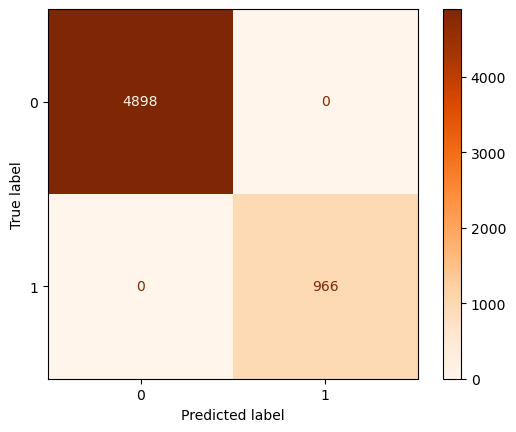

In [82]:
cm = confusion_matrix(y_train, preds)
cmd = ConfusionMatrixDisplay(cm, display_labels=grid_search.best_estimator_.classes_)
cmd.plot(cmap=plt.cm.Oranges)
plt.show()

In [83]:
print(classification_report(y_train, preds, digits=4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      4898
           1     1.0000    1.0000    1.0000       966

    accuracy                         1.0000      5864
   macro avg     1.0000    1.0000    1.0000      5864
weighted avg     1.0000    1.0000    1.0000      5864



In [84]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_features=None, random_state=42)

In [85]:
joblib.dump(rf, 'models/rf.pkl')

['models/rf.pkl']

- tempo de treinamento pode ser pego no gridsearch
- tempo de inferência pode ser calculado com time
```py
import time

start = time.time()
modelo.predict(X_test)
tempo_inferencia = time.time() - start
```
- uso de memória com
```py
from memory_profiler import memory_usage

def uso_de_memoria():
    modelo.predict(X_test)
    return modelo

mem_usage = memory_usage((treinar_modelo, ))
print(f"Memória máxima utilizada: {max(mem_usage)} MB")
```

- complexidade do modelo
`modelo.summary()` para redes neurais

para ver o tamanho
```py
import os
import joblib

joblib.dump(modelo, 'modelo.pkl')
tamanho = os.path.getsize('modelo.pkl')
print(f"Tamanho do modelo: {tamanho/1e6:.2f} MB")
```